# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "RF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'RF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups 
Sample_082  Q96KN2            22.111
Sample_100  P63167;Q96FJ2     15.572
Sample_049  Q6ZVL6            15.721
Sample_105  O75781;O75781-2   16.253
Sample_109  P01008            22.475
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by RF: runs/alzheimer_study/preds/pred_real_na_RF.csv


Sample ID   protein groups
Sample_075  Q9ULB4           10.681
Sample_047  P33151           16.143
Sample_185  Q96SM3           15.819
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.475
            A0A075B6Q5                 12.612
            A0A075B6R2                 12.233
            A0A075B6S5                 11.482
            A0A087WSY4                 14.011
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.969
            Q9UI40;Q9UI40-2            13.241
            Q9UIW2                     13.056
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.138
            Q9UP79                     12.521
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.111,15.050,16.842,19.863,15.692,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.759,19.067,...,15.528,15.576,14.357,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.710,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.661,17.705,17.039,16.643,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,16.327,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.312,15.345,17.084,18.708,14.249,19.433,12.093,11.366
Sample_207,15.739,16.877,15.469,16.898,15.029,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,12.475,...,16.012,15.178,13.321,15.050,16.842,19.863,12.263,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.157,19.067,16.188,...,15.528,15.576,12.623,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.264,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,13.504,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.164,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.533,15.345,17.084,18.708,14.249,19.433,11.112,13.013
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 361.73it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.48it/s]

100%|██████████| 2/2 [00:00<00:00,  5.46it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.22it/s]

100%|██████████| 3/3 [00:00<00:00,  3.64it/s]

100%|██████████| 3/3 [00:00<00:00,  3.86it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.33it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.40it/s]

100%|██████████| 4/4 [00:00<00:00,  3.77it/s]

100%|██████████| 4/4 [00:00<00:00,  4.12it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.38it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.94it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.39it/s]

100%|██████████| 5/5 [00:01<00:00,  4.07it/s]

100%|██████████| 5/5 [00:01<00:00,  4.48it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.15it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.19it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.77it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.57it/s]

100%|██████████| 6/6 [00:01<00:00,  3.50it/s]

100%|██████████| 6/6 [00:01<00:00,  3.74it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.56it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.43it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.58it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.42it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.21it/s]

100%|██████████| 7/7 [00:01<00:00,  3.19it/s]

100%|██████████| 7/7 [00:02<00:00,  3.50it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.83it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.58it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.76it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.57it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.45it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.38it/s]

100%|██████████| 8/8 [00:02<00:00,  3.16it/s]

100%|██████████| 8/8 [00:02<00:00,  3.56it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  3.53it/s]

 33%|███▎      | 3/9 [00:00<00:02,  2.97it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.23it/s]

 56%|█████▌    | 5/9 [00:02<00:02,  1.99it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  1.95it/s]

 78%|███████▊  | 7/9 [00:03<00:00,  2.10it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.27it/s]

100%|██████████| 9/9 [00:03<00:00,  2.39it/s]

100%|██████████| 9/9 [00:03<00:00,  2.32it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.88it/s]

 30%|███       | 3/10 [00:00<00:01,  3.57it/s]

 40%|████      | 4/10 [00:01<00:01,  3.23it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.12it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.17it/s]

 70%|███████   | 7/10 [00:02<00:00,  3.25it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.84it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.66it/s]

100%|██████████| 10/10 [00:03<00:00,  2.70it/s]

100%|██████████| 10/10 [00:03<00:00,  3.00it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.70it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.19it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.23it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.67it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.42it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.23it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.31it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.47it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.62it/s]

100%|██████████| 11/11 [00:04<00:00,  2.72it/s]

100%|██████████| 11/11 [00:04<00:00,  2.73it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.15it/s]

 25%|██▌       | 3/12 [00:01<00:03,  2.61it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.16it/s]

 42%|████▏     | 5/12 [00:02<00:03,  2.19it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.39it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.27it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.07it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  1.89it/s]

 83%|████████▎ | 10/12 [00:04<00:01,  1.97it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  1.94it/s]

100%|██████████| 12/12 [00:05<00:00,  1.97it/s]

100%|██████████| 12/12 [00:05<00:00,  2.13it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.34it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.06it/s]

 31%|███       | 4/13 [00:01<00:03,  2.45it/s]

 38%|███▊      | 5/13 [00:02<00:03,  2.16it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.12it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.32it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.42it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.59it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.63it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.77it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.71it/s]

100%|██████████| 13/13 [00:04<00:00,  2.70it/s]

100%|██████████| 13/13 [00:04<00:00,  2.61it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.51it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.84it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.79it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.44it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.29it/s]

 50%|█████     | 7/14 [00:01<00:02,  3.25it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.22it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.10it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.25it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.48it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.56it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.49it/s]

100%|██████████| 14/14 [00:03<00:00,  3.43it/s]

100%|██████████| 14/14 [00:03<00:00,  3.51it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.85it/s]

 20%|██        | 3/15 [00:00<00:03,  3.95it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.43it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.35it/s]

 40%|████      | 6/15 [00:01<00:02,  3.19it/s]

 47%|████▋     | 7/15 [00:02<00:02,  3.29it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.25it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.27it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.28it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.27it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.37it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.33it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.29it/s]

100%|██████████| 15/15 [00:04<00:00,  3.24it/s]

100%|██████████| 15/15 [00:04<00:00,  3.37it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.071 0.031          0.671 0.414       0.088   
2             0.005 0.005      0.060 0.022          0.805 0.078       0.709   
3             0.004 0.002      0.060 0.019          0.812 0.082       0.730   
4             0.004 0.002      0.049 0.008          0.835 0.083       0.771   
5             0.003 0.001      0.042 0.015          0.830 0.087       0.757   
6             0.004 0.002      0.051 0.014          0.813 0.082       0.747   
7             0.005 0.004      0.073 0.029          0.799 0.088       0.750   
8             0.005 0.003      0.070 0.033          0.806 0.093       0.750   
9             0.004 0.001      0.053 0.013          0.815 0.076       0.814   
10            0.005 0.003      0.059 0.020          0.827 0.084       0.817   
11            0.010 0.010      0.099 0.031          0.823 0.080       0.811   
12            0.007 0.007      0.075 0.027          0.842 0.066       0.837   
13            0.004 0.001      0.042 0.015          0.826 0.076       0.836   
14            0.006 0.005      0.051 0.015          0.823 0.076       0.835   
15            0.006 0.004      0.066 0.022          0.807 0.078       0.828   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.080   0.150 0.123                  0.537 0.038        0.854   
2          0.120   0.748 0.085                  0.791 0.063        0.866   
3          0.121   0.763 0.085                  0.803 0.064        0.870   
4          0.118   0.798 0.087                  0.830 0.070        0.886   
5          0.115   0.788 0.088                  0.822 0.070        0.885   
6          0.125   0.774 0.091                  0.811 0.070        0.881   
7          0.123   0.768 0.089                  0.805 0.070        0.886   
8          0.116   0.773 0.090                  0.808 0.072        0.886   
9          0.119   0.809 0.075                  0.838 0.062        0.907   
10         0.114   0.816 0.073                  0.844 0.060        0.909   
11         0.118   0.811 0.075                  0.840 0.061        0.909   
12         0.105   0.835 0.063                  0.860 0.054        0.915   
13         0.103   0.827 0.071                  0.853 0.061        0.914   
14         0.102   0.825 0.069                  0.851 0.059        0.912   
15         0.106   0.813 0.071                  0.840 0.061        0.908   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.821 0.085        210.000 0.000  
2          0.062                  0.850 0.074        210.000 0.000  
3          0.058                  0.852 0.067        210.000 0.000  
4          0.063                  0.880 0.063        210.000 0.000  
5          0.062                  0.878 0.064        210.000 0.000  
6          0.061                  0.871 0.066        210.000 0.000  
7          0.060                  0.876 0.065        210.000 0.000  
8          0.058                  0.876 0.065        210.000 0.000  
9          0.050                  0.890 0.054        210.000 0.000  
10         0.048                  0.889 0.056        210.000 0.000  
11         0.049                  0.889 0.057        210.000 0.000  
12         0.047                  0.900 0.053        210.000 0.000  
13         0.048                  0.899 0.053        210.000 0.000  
14         0.049                  0.897 0.053        210.000 0.000  
15         0.048                  0.893 0.053 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 436.59it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.05it/s]

100%|██████████| 2/2 [00:00<00:00,  5.01it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.45it/s]

100%|██████████| 3/3 [00:01<00:00,  2.66it/s]

100%|██████████| 3/3 [00:01<00:00,  2.89it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.22it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.43it/s]

100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

100%|██████████| 4/4 [00:01<00:00,  2.21it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.71it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.35it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.02it/s]

100%|██████████| 5/5 [00:02<00:00,  1.97it/s]

100%|██████████| 5/5 [00:02<00:00,  2.15it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.60it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.29it/s]

 67%|██████▋   | 4/6 [00:01<00:01,  1.91it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  1.75it/s]

100%|██████████| 6/6 [00:03<00:00,  1.76it/s]

100%|██████████| 6/6 [00:03<00:00,  1.93it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.96it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.79it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.11it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.74it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.59it/s]

100%|██████████| 7/7 [00:02<00:00,  2.47it/s]

100%|██████████| 7/7 [00:02<00:00,  2.83it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.62it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.55it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.25it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  1.90it/s]

 75%|███████▌  | 6/8 [00:02<00:01,  1.78it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  1.78it/s]

100%|██████████| 8/8 [00:03<00:00,  1.94it/s]

100%|██████████| 8/8 [00:03<00:00,  2.11it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.15it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.29it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.96it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.86it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.88it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.85it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.75it/s]

100%|██████████| 9/9 [00:03<00:00,  2.76it/s]

100%|██████████| 9/9 [00:03<00:00,  2.91it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.68it/s]

 30%|███       | 3/10 [00:00<00:01,  3.84it/s]

 40%|████      | 4/10 [00:01<00:01,  3.54it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.25it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.77it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.31it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.05it/s]

 90%|█████████ | 9/10 [00:03<00:00,  1.89it/s]

100%|██████████| 10/10 [00:04<00:00,  1.96it/s]

100%|██████████| 10/10 [00:04<00:00,  2.39it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.82it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.20it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.52it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.23it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.33it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.38it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.39it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.30it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.29it/s]

100%|██████████| 11/11 [00:04<00:00,  2.36it/s]

100%|██████████| 11/11 [00:04<00:00,  2.46it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.03it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.26it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.94it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.76it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.62it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.60it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.73it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.65it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.73it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.77it/s]

100%|██████████| 12/12 [00:04<00:00,  2.32it/s]

100%|██████████| 12/12 [00:04<00:00,  2.65it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.33it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.99it/s]

 31%|███       | 4/13 [00:01<00:02,  3.37it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.16it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.98it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.94it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.84it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.60it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.42it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.03it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  1.83it/s]

100%|██████████| 13/13 [00:05<00:00,  1.66it/s]

100%|██████████| 13/13 [00:05<00:00,  2.34it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.45it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.01it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.59it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.21it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.03it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.36it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.10it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  1.91it/s]

 71%|███████▏  | 10/14 [00:04<00:02,  1.67it/s]

 79%|███████▊  | 11/14 [00:05<00:01,  1.60it/s]

 86%|████████▌ | 12/14 [00:05<00:01,  1.68it/s]

 93%|█████████▎| 13/14 [00:06<00:00,  1.76it/s]

100%|██████████| 14/14 [00:06<00:00,  1.82it/s]

100%|██████████| 14/14 [00:06<00:00,  2.12it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.65it/s]

 20%|██        | 3/15 [00:01<00:04,  2.70it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.25it/s]

 33%|███▎      | 5/15 [00:02<00:04,  2.27it/s]

 40%|████      | 6/15 [00:02<00:03,  2.26it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.36it/s]

 53%|█████▎    | 8/15 [00:03<00:02,  2.41it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.32it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  1.94it/s]

 73%|███████▎  | 11/15 [00:05<00:02,  1.75it/s]

 80%|████████  | 12/15 [00:05<00:01,  1.78it/s]

 87%|████████▋ | 13/15 [00:06<00:01,  1.78it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  1.92it/s]

100%|██████████| 15/15 [00:07<00:00,  2.07it/s]

100%|██████████| 15/15 [00:07<00:00,  2.12it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.005      0.070 0.026          0.000 0.000       0.000   
2             0.005 0.005      0.064 0.026          0.705 0.198       0.246   
3             0.006 0.005      0.078 0.031          0.626 0.110       0.478   
4             0.005 0.003      0.056 0.016          0.593 0.125       0.458   
5             0.004 0.001      0.058 0.027          0.637 0.109       0.560   
6             0.005 0.004      0.063 0.025          0.650 0.088       0.601   
7             0.006 0.005      0.067 0.025          0.645 0.085       0.596   
8             0.005 0.003      0.067 0.028          0.684 0.106       0.614   
9             0.007 0.006      0.082 0.039          0.681 0.114       0.599   
10            0.005 0.004      0.069 0.033          0.755 0.094       0.771   
11            0.006 0.005      0.066 0.025          0.748 0.094       0.767   
12            0.008 0.006      0.079 0.031          0.767 0.099       0.782   
13            0.007 0.007      0.071 0.034          0.784 0.092       0.785   
14            0.006 0.004      0.063 0.026          0.782 0.100       0.778   
15            0.005 0.002      0.053 0.015          0.788 0.095       0.782   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.498 0.006        0.844   
2          0.106   0.351 0.127                  0.584 0.047        0.658   
3          0.121   0.535 0.106                  0.633 0.072        0.723   
4          0.133   0.507 0.116                  0.612 0.075        0.718   
5          0.110   0.590 0.091                  0.661 0.071        0.737   
6          0.098   0.619 0.071                  0.679 0.058        0.758   
7          0.099   0.614 0.071                  0.676 0.056        0.754   
8          0.107   0.641 0.089                  0.701 0.070        0.765   
9          0.116   0.631 0.098                  0.695 0.075        0.761   
10         0.111   0.757 0.078                  0.791 0.066        0.878   
11         0.117   0.752 0.083                  0.787 0.071        0.879   
12         0.119   0.768 0.084                  0.802 0.071        0.890   
13         0.122   0.778 0.083                  0.812 0.070        0.893   
14         0.111   0.775 0.084                  0.808 0.071        0.892   
15         0.113   0.780 0.081                  0.812 0.068        0.894   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.818 0.088        210.000 0.000  
2          0.101                  0.639 0.100        210.000 0.000  
3          0.077                  0.654 0.089        210.000 0.000  
4          0.077                  0.639 0.089        210.000 0.000  
5          0.073                  0.667 0.094        210.000 0.000  
6          0.072                  0.698 0.096        210.000 0.000  
7          0.071                  0.691 0.093        210.000 0.000  
8          0.077                  0.703 0.100        210.000 0.000  
9          0.077                  0.700 0.098        210.000 0.000  
10         0.059                  0.850 0.069        210.000 0.000  
11         0.058                  0.855 0.068        210.000 0.000  
12         0.055                  0.872 0.062        210.000 0.000  
13         0.055                  0.876 0.061        210.000 0.000  
14         0.054                  0.874 0.062        210.000 0.000  
15         0.053                  0.876 0.062 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 974.97it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 16.75it/s]

100%|██████████| 2/2 [00:00<00:00, 16.57it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 18.01it/s]

100%|██████████| 3/3 [00:00<00:00, 17.87it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 17.42it/s]

100%|██████████| 4/4 [00:00<00:00, 10.07it/s]

100%|██████████| 4/4 [00:00<00:00, 10.11it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 21.07it/s]

100%|██████████| 5/5 [00:00<00:00, 14.61it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 16.71it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 10.43it/s]

100%|██████████| 6/6 [00:00<00:00,  9.69it/s]

100%|██████████| 6/6 [00:00<00:00, 10.04it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 22.07it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 14.33it/s]

100%|██████████| 7/7 [00:00<00:00, 14.66it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 16.73it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 12.69it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 11.55it/s]

100%|██████████| 8/8 [00:00<00:00, 12.33it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 16.34it/s]

 44%|████▍     | 4/9 [00:00<00:00,  9.74it/s]

 67%|██████▋   | 6/9 [00:00<00:00,  8.98it/s]

 78%|███████▊  | 7/9 [00:00<00:00,  8.68it/s]

 89%|████████▉ | 8/9 [00:00<00:00,  8.55it/s]

100%|██████████| 9/9 [00:00<00:00,  9.28it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 16.71it/s]

 50%|█████     | 5/10 [00:00<00:00, 13.14it/s]

 70%|███████   | 7/10 [00:00<00:00, 11.56it/s]

 90%|█████████ | 9/10 [00:00<00:00, 11.29it/s]

100%|██████████| 10/10 [00:00<00:00, 11.80it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 16.62it/s]

 45%|████▌     | 5/11 [00:00<00:00, 12.03it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 10.26it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 10.50it/s]

100%|██████████| 11/11 [00:00<00:00, 11.41it/s]

100%|██████████| 11/11 [00:00<00:00, 11.42it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 17.63it/s]

 33%|███▎      | 4/12 [00:00<00:00, 13.92it/s]

 50%|█████     | 6/12 [00:00<00:00, 14.34it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 14.38it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 14.42it/s]

100%|██████████| 12/12 [00:00<00:00, 14.65it/s]

100%|██████████| 12/12 [00:00<00:00, 14.59it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 17.79it/s]

 38%|███▊      | 5/13 [00:00<00:00, 12.02it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 12.51it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 12.25it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 12.11it/s]

100%|██████████| 13/13 [00:01<00:00, 11.67it/s]

100%|██████████| 13/13 [00:01<00:00, 12.19it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 18.05it/s]

 29%|██▊       | 4/14 [00:00<00:00, 12.10it/s]

 43%|████▎     | 6/14 [00:00<00:00,  9.56it/s]

 57%|█████▋    | 8/14 [00:00<00:00,  9.58it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 10.03it/s]

 86%|████████▌ | 12/14 [00:01<00:00, 10.44it/s]

100%|██████████| 14/14 [00:01<00:00, 10.45it/s]

100%|██████████| 14/14 [00:01<00:00, 10.47it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 19.10it/s]

 33%|███▎      | 5/15 [00:00<00:00, 15.93it/s]

 47%|████▋     | 7/15 [00:00<00:00, 14.88it/s]

 60%|██████    | 9/15 [00:00<00:00, 13.96it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 13.18it/s]

 87%|████████▋ | 13/15 [00:00<00:00, 13.07it/s]

100%|██████████| 15/15 [00:01<00:00, 12.65it/s]

100%|██████████| 15/15 [00:01<00:00, 13.58it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.069 0.030          0.000 0.000       0.000   
2             0.006 0.005      0.069 0.031          0.332 0.448       0.031   
3             0.005 0.004      0.070 0.028          0.595 0.133       0.357   
4             0.004 0.001      0.062 0.027          0.613 0.124       0.359   
5             0.006 0.007      0.069 0.026          0.618 0.126       0.345   
6             0.005 0.003      0.052 0.018          0.607 0.124       0.341   
7             0.007 0.006      0.077 0.028          0.646 0.096       0.517   
8             0.005 0.003      0.064 0.025          0.634 0.110       0.545   
9             0.005 0.004      0.061 0.022          0.629 0.102       0.541   
10            0.006 0.005      0.061 0.022          0.656 0.110       0.596   
11            0.004 0.003      0.040 0.017          0.649 0.115       0.593   
12            0.007 0.005      0.071 0.029          0.672 0.101       0.630   
13            0.004 0.002      0.051 0.012          0.666 0.096       0.619   
14            0.005 0.004      0.056 0.019          0.680 0.101       0.628   
15            0.005 0.004      0.063 0.026          0.679 0.086       0.641   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.731   
2          0.044   0.055 0.078                  0.504 0.031        0.594   
3          0.109   0.439 0.110                  0.589 0.065        0.663   
4          0.092   0.447 0.094                  0.595 0.059        0.667   
5          0.105   0.436 0.105                  0.594 0.062        0.666   
6          0.105   0.429 0.107                  0.590 0.061        0.660   
7          0.115   0.566 0.090                  0.653 0.061        0.751   
8          0.100   0.579 0.078                  0.653 0.063        0.750   
9          0.105   0.575 0.079                  0.651 0.060        0.746   
10         0.125   0.615 0.092                  0.679 0.069        0.766   
11         0.126   0.611 0.097                  0.675 0.075        0.762   
12         0.120   0.645 0.092                  0.701 0.073        0.782   
13         0.116   0.635 0.085                  0.694 0.067        0.785   
14         0.109   0.647 0.084                  0.703 0.066        0.791   
15         0.106   0.654 0.078                  0.708 0.061        0.791   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.072                  0.677 0.090        210.000 0.000  
2          0.095                  0.548 0.099        210.000 0.000  
3          0.079                  0.606 0.087        210.000 0.000  
4          0.075                  0.600 0.083        210.000 0.000  
5          0.075                  0.601 0.082        210.000 0.000  
6          0.075                  0.594 0.081        210.000 0.000  
7          0.067                  0.702 0.081        210.000 0.000  
8          0.067                  0.697 0.081        210.000 0.000  
9          0.068                  0.693 0.083        210.000 0.000  
10         0.073                  0.714 0.086        210.000 0.000  
11         0.074                  0.711 0.089        210.000 0.000  
12         0.075                  0.726 0.089        210.000 0.000  
13         0.074                  0.740 0.085        210.000 0.000  
14         0.069                  0.752 0.082        210.000 0.000  
15         0.070                  0.750 0.084 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,11,12,7
score_time,11,9,7
test_precision,12,15,14
test_recall,12,13,15
test_f1,12,15,15
test_balanced_accuracy,12,15,15
test_roc_auc,12,15,14
test_average_precision,12,13,14
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.70it/s]

 20%|██        | 3/15 [00:00<00:03,  3.36it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.99it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.79it/s]

 40%|████      | 6/15 [00:01<00:03,  2.83it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.81it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.82it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.52it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.48it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.54it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.64it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.66it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.30it/s]

100%|██████████| 15/15 [00:05<00:00,  2.09it/s]

100%|██████████| 15/15 [00:05<00:00,  2.57it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 18.78it/s]

 29%|██▊       | 4/14 [00:00<00:00, 14.53it/s]

 43%|████▎     | 6/14 [00:00<00:00, 13.81it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 11.47it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 12.14it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 11.63it/s]

100%|██████████| 14/14 [00:01<00:00, 11.70it/s]

100%|██████████| 14/14 [00:01<00:00, 12.23it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.92it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.22it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.54it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.12it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.99it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.87it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.97it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.04it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.99it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.03it/s]

100%|██████████| 12/12 [00:03<00:00,  2.84it/s]

100%|██████████| 12/12 [00:03<00:00,  3.11it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf


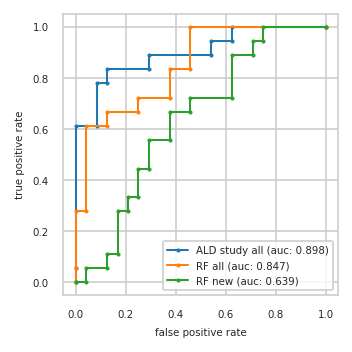

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       RF all       RF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.042 0.000
2          0.000 0.611  0.000 0.278  0.042 0.056
3          0.083 0.611  0.042 0.278  0.125 0.056
4          0.083 0.778  0.042 0.611  0.125 0.111
5          0.125 0.778  0.125 0.611  0.167 0.111
6          0.125 0.833  0.125 0.667  0.167 0.278
7          0.292 0.833  0.250 0.667  0.208 0.278
8          0.292 0.889  0.250 0.722  0.208 0.333
9          0.542 0.889  0.375 0.722  0.250 0.333
10         0.542 0.944  0.375 0.833  0.250 0.444
11         0.625 0.944  0.458 0.833  0.292 0.444
12         0.625 1.000  0.458 1.000  0.292 0.556
13         1.000 1.000  1.000 1.000  0.375 0.556
14           NaN   NaN    NaN   NaN  0.375 0.667
15           NaN   NaN    NaN   NaN  0.458 0.667
16           NaN   NaN    NaN   NaN  0.458 0.722
17           NaN   NaN    NaN   NaN  0.625 0.722
18           NaN   NaN    NaN   NaN  0.625 0.889
19           NaN   NaN    NaN   NaN  0.708 0.889
20           NaN   NaN    NaN   NaN  0.708 0.944
21           NaN   NaN    NaN   NaN  0.750 0.944
22           NaN   NaN    NaN   NaN  0.750 1.000
23           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,RF all,RF new
rank,,,
0,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,Q14894
1,Q8NBI6,Q9HAT2,A0A087WTT8;A0A0A0MQX5;O94779;O94779-2
2,Q16674;W4VSR3,P10636-2;P10636-6,P31150
3,P61981,P14174,A0A075B7B8
4,P14174,P61981,Q96GD0
5,P04075,P04075,P31321
6,Q9Y2T3;Q9Y2T3-3,Q14894,E9PK25;G3V1A4;P23528
7,P00338;P00338-3,A0A0C4DGY8;D6RA00;Q9UHY7,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
8,P63104,P63104,P10745


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf


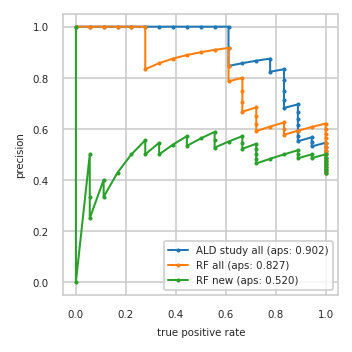

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          RF all          RF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.485 0.889
10         0.531 0.944     0.562 1.000     0.500 0.889
11         0.548 0.944     0.581 1.000     0.516 0.889
12         0.567 0.944     0.600 1.000     0.500 0.833
13         0.552 0.889     0.621 1.000     0.483 0.778
14         0.571 0.889     0.607 0.944     0.464 0.722
15         0.593 0.889     0.593 0.889     0.481 0.722
16         0.615 0.889     0.577 0.833     0.500 0.722
17         0.640 0.889     0.600 0.833     0.520 0.722
18         0.667 0.889     0.625 0.833     0.542 0.722
19         0.696 0.889     0.609 0.778     0.522 0.667
20         0.682 0.833     0.591 0.722     0.545 0.667
21         0.714 0.833     0.619 0.722     0.571 0.667
22         0.750 0.833     0.650 0.722     0.550 0.611
23         0.789 0.833     0.684 0.722     0.526 0.556
24         0.833 0.833     0.667 0.667     0.556 0.556
25         0.824 0.778     0.706 0.667     0.588 0.556
26         0.875 0.778     0.750 0.667     0.562 0.500
27         0.867 0.722     0.800 0.667     0.533 0.444
28         0.857 0.667     0.786 0.611     0.571 0.444
29         0.846 0.611     0.846 0.611     0.538 0.389
30         0.917 0.611     0.917 0.611     0.500 0.333
31         1.000 0.611     0.909 0.556     0.545 0.333
32         1.000 0.556     0.900 0.500     0.500 0.278
33         1.000 0.500     0.889 0.444     0.556 0.278
34         1.000 0.444     0.875 0.389     0.500 0.222
35         1.000 0.389     0.857 0.333     0.429 0.167
36         1.000 0.333     0.833 0.278     0.333 0.111
37         1.000 0.278     1.000 0.278     0.400 0.111
38         1.000 0.222     1.000 0.222     0.250 0.056
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf


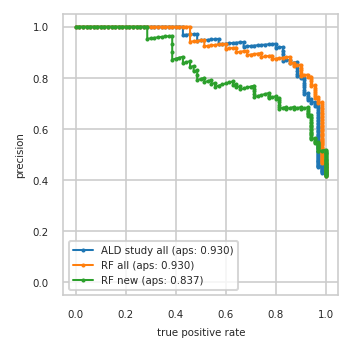

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf


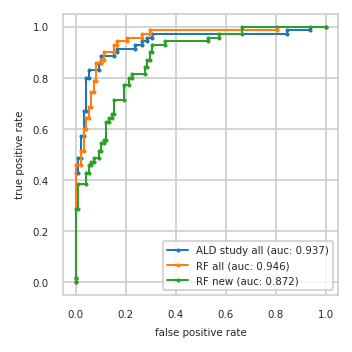

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_RF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF all.pkl'),
 'results_RF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf')}